In [1]:
#@title imports and some boilerplate functions
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import os
import shutil
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

try:
  import wandb
except:
  # WandB – Install the W&B library
  !pip install wandb -q
  import wandb
  


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class Unflatten(nn.Module):
    def __init__(self, channel, height, width):
        super(Unflatten, self).__init__()
        self.channel = channel
        self.height = height
        self.width = width

    def forward(self, input):
        return input.view(input.size(0), self.channel, self.height, self.width)




     |████████████████████████████████| 1.8MB 6.1MB/s 
     |████████████████████████████████| 102kB 12.2MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
     |████████████████████████████████| 133kB 47.8MB/s 
     |████████████████████████████████| 163kB 40.9MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 


In [2]:

class ConvVAE(nn.Module):

    def __init__(self, latent_size):
        super(ConvVAE, self).__init__()

        self.latent_size = latent_size

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            ###############################
            # nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            # nn.ReLU(),
            ######################################
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            Flatten(),
            nn.Linear(6272, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU()
        )

        # hidden => mu
        self.fc1 = nn.Linear(512, self.latent_size)
        # hidden => logvar
        self.fc2 = nn.Linear(512, self.latent_size)

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 6272),
            nn.ReLU(),
            Unflatten(128, 7, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc1(h), self.fc2(h)
        return mu, logvar

    def decode(self, z):
        z = self.decoder(z)
        return z

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    # reconstruction loss
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch, model, train_loader, optimizer,wandb_log_status = False):
    model.train()
    train_loss = 0

    if torch.cuda.is_available():
      device_available = torch.device("cuda")  
    else: 
      device_available = torch.device("cpu")
    print(device_available)

    try:
      if(wandb_log_status == True):
        wandb.watch(model, log="all")
    except:  
      pass
    
    for batch_idx, (data, _) in tqdm(enumerate(train_loader), total=len(train_loader), desc='train'):
        data = data.to(device_available)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

        loss = loss_function(recon_batch, data, mu, logvar)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    if(wandb_log_status == True):
      wandb.log({"Train Loss": train_loss})

    return train_loss


def test(epoch, model, test_loader, batch_size, wandb_log_status = False):
    model.eval()
    test_loss = 0
    if torch.cuda.is_available():
      device_available = torch.device("cuda")  
    else: 
      device_available = torch.device("cpu")
    print(device_available)
    with torch.no_grad():
        for batch_idx, (data, _) in tqdm(enumerate(test_loader), total=len(test_loader), desc='test'):
            data = data.to(device_available)

            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

            if batch_idx == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch.view(batch_size, 1, 28, 28)[:n]]).cpu()
                img = make_grid(comparison)
                # save_image(img, "images/%d.png" % epoch)
                save_image(comparison.cpu(), 'reconstruction/' + str(epoch) + '.png', nrow=n)
                name = name = "/content/reconstruction/" + str(epoch) +".png"
                img = mpimg.imread(name)
                imgplot = plt.imshow(img)
                plt.show()
    test_loss /= len(test_loader.dataset)
    if(wandb_log_status == True):
      wandb.log({"Test Loss": test_loss})
    return test_loss


def save_checkpoint(state, is_best, outdir='checkpoint'):
    checkpoint_file = os.path.join(outdir, 'checkpoint.pth')
    best_file = os.path.join(outdir, 'model_best.pth')
    torch.save(state, checkpoint_file)
    if is_best:
        shutil.copyfile(checkpoint_file, best_file)

In [3]:
#@title Hyperparameters and datasaet

batch_size = 100

os.makedirs("reconstruction", exist_ok=True)
os.makedirs("sampling", exist_ok=True)
os.makedirs("checkpoint", exist_ok=True)

cuda = torch.cuda.is_available()
if cuda:
    print('cuda available')
device = torch.device("cuda" if cuda else "cpu")

path_data = "/content"
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(path_data, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(path_data, train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

cuda available


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw




Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
latent_size = 60
epochs = 30


model = ConvVAE(latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(model)

ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten()
    (5): Linear(in_features=6272, out_features=1024, bias=True)
    (6): ReLU()
    (7): Linear(in_features=1024, out_features=512, bias=True)
    (8): ReLU()
  )
  (fc1): Linear(in_features=512, out_features=60, bias=True)
  (fc2): Linear(in_features=512, out_features=60, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=60, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=6272, bias=True)
    (5): ReLU()
    (6): Unflatten()
    (7): ReLU()
    (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

In [ ]:
# Enter your api key in the second last line (the command is !wandb login <apikey>) and set your project name variable accordingly.

flag_wandb_log_status = False
wandb_run_name = "4layer_VAE_" + str(latent_size) + "LS"



project_name = ""
# WandB – Login to your wandb account so you can log all your metrics
if(flag_wandb_log_status == True):
  !wandb login ###
  run_object = wandb.init(name = wandb_run_name,project=project_name)

cuda


train: 100%|██████████| 600/600 [00:09<00:00, 65.18it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

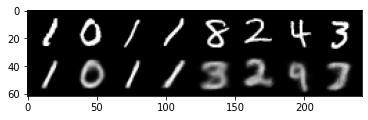

test: 100%|██████████| 100/100 [00:01<00:00, 83.06it/s]


Epoch [1/30] loss: 179.903 val_loss: 150.970


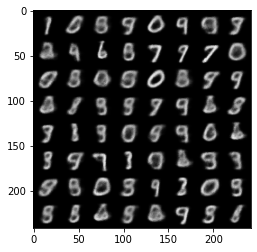

cuda


train: 100%|██████████| 600/600 [00:08<00:00, 67.27it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

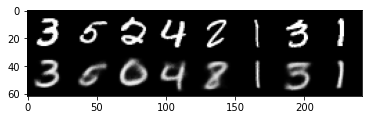

test: 100%|██████████| 100/100 [00:01<00:00, 86.65it/s]


Epoch [2/30] loss: 135.383 val_loss: 135.691


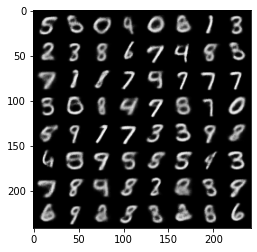

cuda


train: 100%|██████████| 600/600 [00:08<00:00, 67.95it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

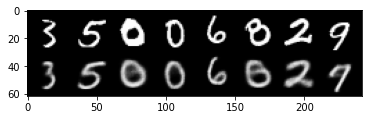

test: 100%|██████████| 100/100 [00:01<00:00, 85.01it/s]


Epoch [3/30] loss: 125.734 val_loss: 125.731


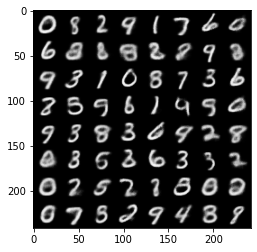

cuda


train: 100%|██████████| 600/600 [00:09<00:00, 62.90it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

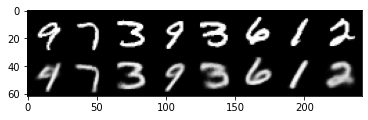

test: 100%|██████████| 100/100 [00:01<00:00, 82.62it/s]


Epoch [4/30] loss: 120.589 val_loss: 118.299


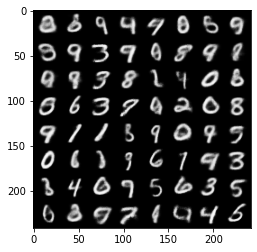

cuda


train: 100%|██████████| 600/600 [00:08<00:00, 67.29it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

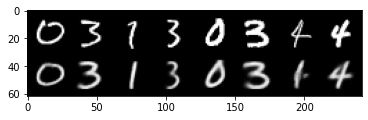

test: 100%|██████████| 100/100 [00:01<00:00, 84.28it/s]


Epoch [5/30] loss: 115.944 val_loss: 112.806


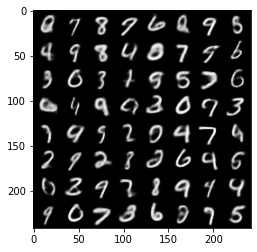

cuda


train: 100%|██████████| 600/600 [00:08<00:00, 67.45it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

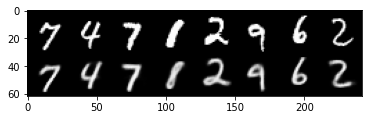

test: 100%|██████████| 100/100 [00:01<00:00, 88.04it/s]


Epoch [6/30] loss: 112.689 val_loss: 108.907


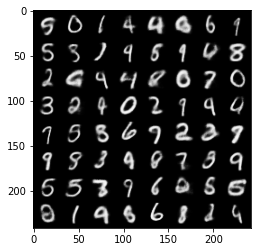

cuda


train: 100%|██████████| 600/600 [00:08<00:00, 67.55it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

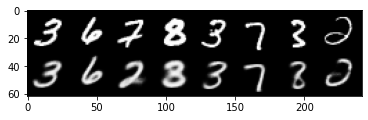

test: 100%|██████████| 100/100 [00:01<00:00, 84.89it/s]


Epoch [7/30] loss: 110.865 val_loss: 107.552


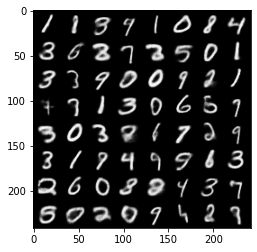

cuda


train: 100%|██████████| 600/600 [00:08<00:00, 66.96it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

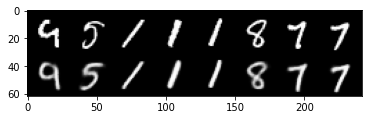

test: 100%|██████████| 100/100 [00:01<00:00, 86.75it/s]


Epoch [8/30] loss: 109.747 val_loss: 105.539


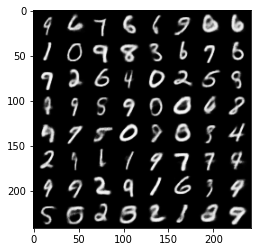

cuda


train: 100%|██████████| 600/600 [00:08<00:00, 66.87it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

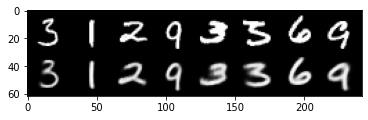

test: 100%|██████████| 100/100 [00:01<00:00, 78.82it/s]


Epoch [9/30] loss: 108.809 val_loss: 105.735


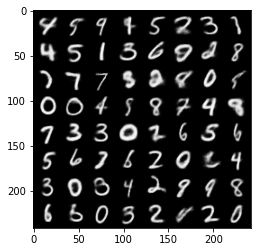

cuda


train: 100%|██████████| 600/600 [00:08<00:00, 67.05it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

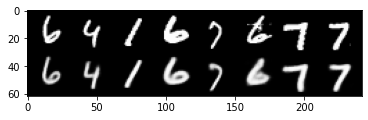

test: 100%|██████████| 100/100 [00:01<00:00, 73.66it/s]


Epoch [10/30] loss: 107.882 val_loss: 104.292


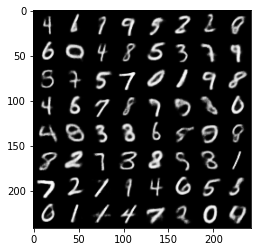

cuda


train: 100%|██████████| 600/600 [00:08<00:00, 67.76it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

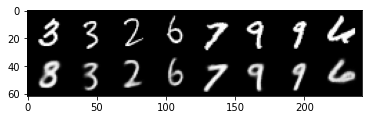

test: 100%|██████████| 100/100 [00:01<00:00, 85.58it/s]


Epoch [11/30] loss: 107.336 val_loss: 103.344


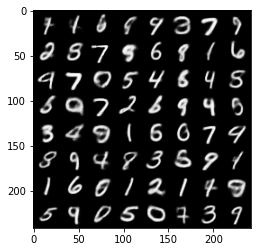

cuda


train: 100%|██████████| 600/600 [00:09<00:00, 66.36it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

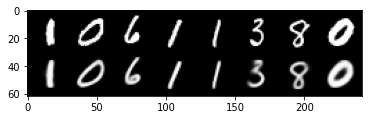

test: 100%|██████████| 100/100 [00:01<00:00, 87.95it/s]


Epoch [12/30] loss: 106.727 val_loss: 103.877


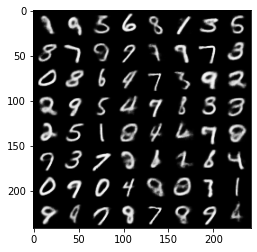

cuda


train: 100%|██████████| 600/600 [00:09<00:00, 64.21it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

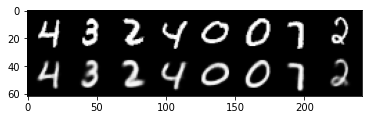

test: 100%|██████████| 100/100 [00:01<00:00, 85.30it/s]


Epoch [13/30] loss: 106.158 val_loss: 103.359


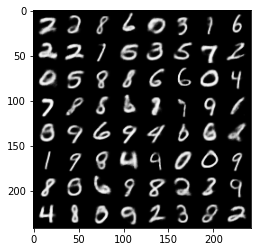

cuda


train: 100%|██████████| 600/600 [00:08<00:00, 67.01it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

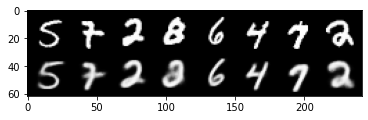

test: 100%|██████████| 100/100 [00:01<00:00, 86.78it/s]


Epoch [14/30] loss: 105.716 val_loss: 102.902


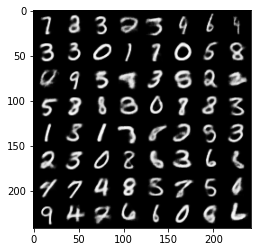

cuda


train: 100%|██████████| 600/600 [00:09<00:00, 65.59it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

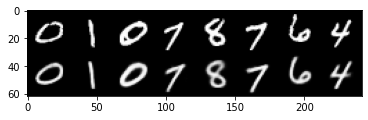

test: 100%|██████████| 100/100 [00:01<00:00, 72.15it/s]


Epoch [15/30] loss: 105.254 val_loss: 102.615


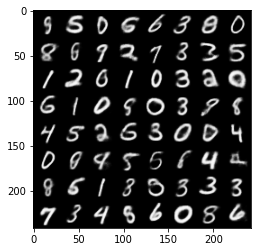

cuda


train: 100%|██████████| 600/600 [00:09<00:00, 65.93it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

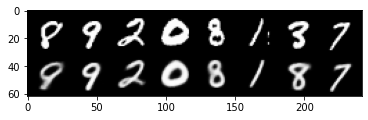

test: 100%|██████████| 100/100 [00:01<00:00, 82.59it/s]


Epoch [16/30] loss: 104.820 val_loss: 102.582


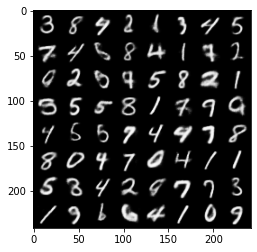

cuda


train: 100%|██████████| 600/600 [00:09<00:00, 66.38it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

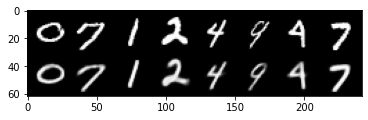

test: 100%|██████████| 100/100 [00:01<00:00, 80.63it/s]


Epoch [17/30] loss: 104.531 val_loss: 102.130


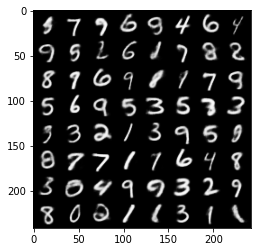

cuda


train: 100%|██████████| 600/600 [00:09<00:00, 62.81it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

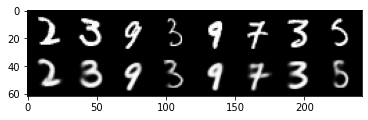

test: 100%|██████████| 100/100 [00:01<00:00, 79.97it/s]


Epoch [18/30] loss: 104.134 val_loss: 102.392


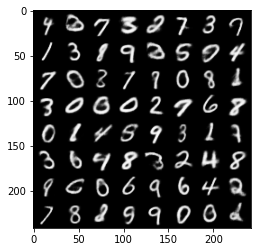

cuda


train: 100%|██████████| 600/600 [00:09<00:00, 66.56it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

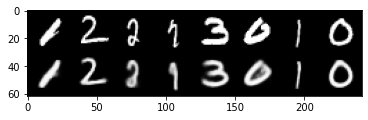

test: 100%|██████████| 100/100 [00:01<00:00, 86.59it/s]


Epoch [19/30] loss: 103.854 val_loss: 102.097


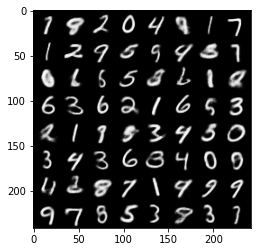

cuda


train: 100%|██████████| 600/600 [00:09<00:00, 63.54it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

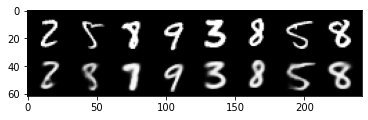

test: 100%|██████████| 100/100 [00:01<00:00, 85.32it/s]


Epoch [20/30] loss: 103.622 val_loss: 102.124


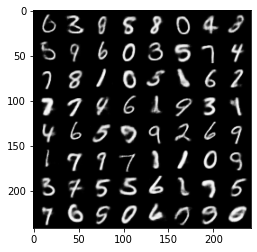

cuda


train: 100%|██████████| 600/600 [00:09<00:00, 65.60it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

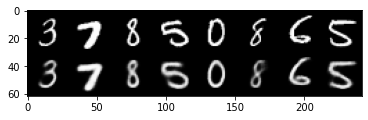

test: 100%|██████████| 100/100 [00:01<00:00, 84.14it/s]


Epoch [21/30] loss: 103.274 val_loss: 101.425


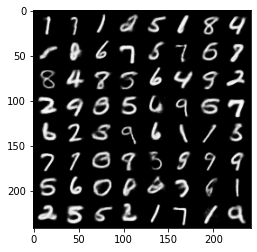

cuda


train: 100%|██████████| 600/600 [00:10<00:00, 57.75it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

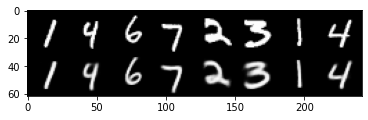

test: 100%|██████████| 100/100 [00:01<00:00, 70.84it/s]


Epoch [22/30] loss: 102.987 val_loss: 101.620


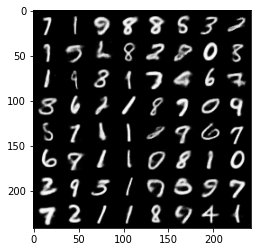

cuda


train: 100%|██████████| 600/600 [00:10<00:00, 59.05it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

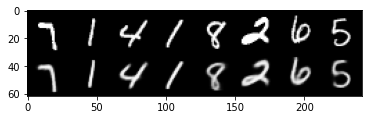

test: 100%|██████████| 100/100 [00:01<00:00, 73.25it/s]


Epoch [23/30] loss: 102.788 val_loss: 102.047


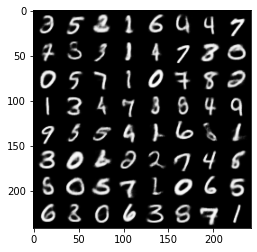

cuda


train: 100%|██████████| 600/600 [00:10<00:00, 59.11it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

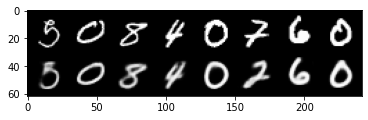

test: 100%|██████████| 100/100 [00:01<00:00, 80.00it/s]


Epoch [24/30] loss: 102.546 val_loss: 101.298


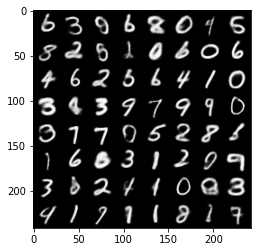

cuda


train: 100%|██████████| 600/600 [00:10<00:00, 58.58it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

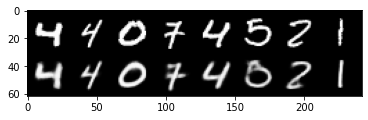

test: 100%|██████████| 100/100 [00:01<00:00, 63.41it/s]


Epoch [25/30] loss: 102.407 val_loss: 101.551


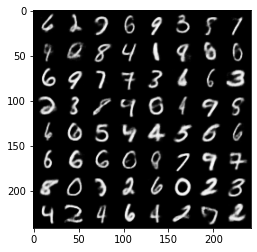

cuda


train: 100%|██████████| 600/600 [00:10<00:00, 58.08it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

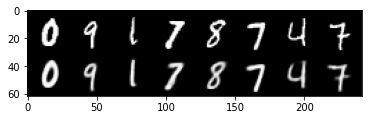

test: 100%|██████████| 100/100 [00:01<00:00, 77.00it/s]


Epoch [26/30] loss: 102.129 val_loss: 101.433


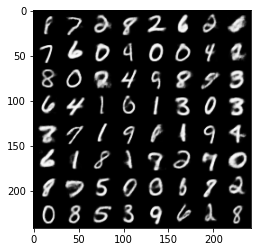

cuda


train: 100%|██████████| 600/600 [00:09<00:00, 60.33it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

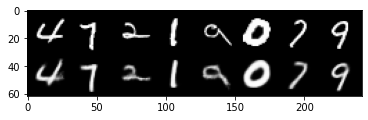

test: 100%|██████████| 100/100 [00:01<00:00, 82.16it/s]


Epoch [27/30] loss: 101.934 val_loss: 101.678


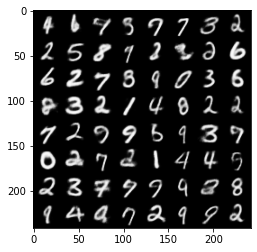

cuda


train: 100%|██████████| 600/600 [00:09<00:00, 62.55it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

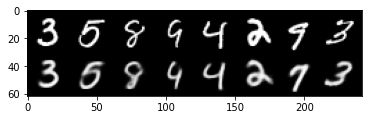

test: 100%|██████████| 100/100 [00:01<00:00, 83.02it/s]


Epoch [28/30] loss: 101.742 val_loss: 101.545


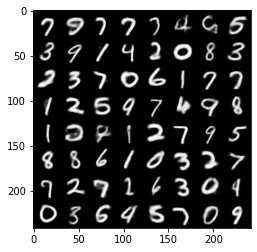

cuda


train: 100%|██████████| 600/600 [00:09<00:00, 61.82it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

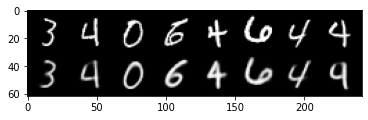

test: 100%|██████████| 100/100 [00:01<00:00, 73.32it/s]


Epoch [29/30] loss: 101.563 val_loss: 101.293


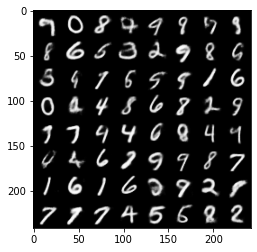

cuda


train: 100%|██████████| 600/600 [00:10<00:00, 59.23it/s]

cuda



test:   0%|          | 0/100 [00:00<?, ?it/s]

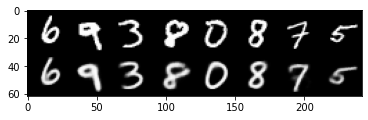

test: 100%|██████████| 100/100 [00:01<00:00, 70.50it/s]


Epoch [30/30] loss: 101.439 val_loss: 101.519


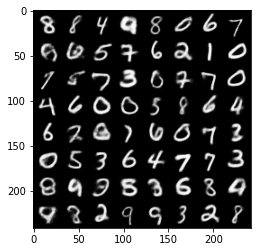

In [5]:

torch.manual_seed(1)
start_epoch = 0

best_test_loss = np.finfo('f').max

for epoch in range(start_epoch, epochs):
    train_loss = train(epoch, model, train_loader, optimizer,wandb_log_status = flag_wandb_log_status)
    test_loss = test(epoch, model, test_loader, batch_size, wandb_log_status = flag_wandb_log_status)
    print('Epoch [%d/%d] loss: %.3f val_loss: %.3f' % (epoch + 1, epochs, train_loss, test_loss))

    is_best = test_loss < best_test_loss
    best_test_loss = min(test_loss, best_test_loss)
    save_checkpoint({
        'epoch': epoch,
        'best_test_loss': best_test_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, is_best)

    with torch.no_grad():
        sample = torch.randn(64, latent_size).to(device)
        sample = model.decode(sample).cpu()
        img = make_grid(sample)

        save_image(sample.view(64, 1, 28, 28), 'sampling/' + str(epoch) + '.png')
        name = name = "/content/sampling/" + str(epoch) +".png"
        img = mpimg.imread(name)
        imgplot = plt.imshow(img)
        plt.show()
if(flag_wandb_log_status == True):
  run_object.finish()

In [ ]:
# This cell is for producing outputs from the trained model.
# Make sure the model is trained before you run this.
for i in range(10):
  with torch.no_grad():
    sample = torch.randn(64, latent_size).to(device)
    gen_imgs = model.decode(sample).cpu()
    print(gen_imgs.shape)
    save_image(gen_imgs.data[:64], "sample.png" , nrow=8, normalize=True)
    img = mpimg.imread('/content/sample.png')
    imgplot = plt.imshow(img[:,:,0], cmap='binary_r')
    plt.show()